In [5]:
############################
### IMPORT USED PACKAGES ###
############################

%matplotlib inline
import networkx as nx
import random
import time
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML



########################
### USEFUL FUNCTIONS ###
########################

# Given a list of (consecutively adjacent) nodes, returns the list of edges connecting them.
def edges_connecting_nodes(node_list):
    """ 
    INPUT:  list of consecutively adjacent nodes (e.g. nodes of a RW trajectory).
    OUTPUT: list of edges connecting the nodes.                                  
    """
    edge_list = []
    for j in range(len(node_list)-1):
        edge_list.append((node_list[j],node_list[j+1]))
    return edge_list


# Draw the graph with the requested preferences
def draw_net(G, position, node_size, node_color, edgelist, width):
    """ 
    INPUT:  G          = a networkx graph. 
            position   = a dictionary with nodes as keys and corresponding positions as values.   
            node_size  = size of nodes (scalar or list with the same length as G.nodes()).
            node_color = color of nodes (string or rgb(rgba) or list with the same length as G.nodes()).  
            edgelist   = list of edges to be drawn.
            width      = line width of edges.
    """
    nx.draw_networkx(
        G, 
        pos = position, 
        with_labels = False,
        node_size = node_size, 
        node_color = node_color,
        edgelist = edgelist,
        width = width
    )

    
# Auto-positioning of nodes in 2d lattice
def auto_pos(graph2d):
    """
    INPUT:  graph2d = a network 2d grid graph
    OUTPUT: position = dictionary with correct positions of the 2d grid graph
    """
    position = {}
    for node in graph2d.nodes():
        position[node] = node

    return position



##########################
### WILSON'S ALGORITHM ###
##########################

# Wilson's algorithm (RSF modification) for a 2d lattice
def wilson_RSF_grid_2d(dim, q, info=True):
    """
    INPUT:  dim  = 2-tuple (n,m) with dimensions of the 2d lattice.
            q    = killing parameter for the loop-erased RWs of the Wilson's algorithm.
            info = boolean to choose whether or not to show concluding information.
    
    OUTPUT: G            = 2d grid graph.
            RW_node      = list of the node positions of the RWs at each step of the algorithm.
            edge_list    = list of lists, each one containing the edges covered by the LERWs at each step.
            roots        = roots found by the Wilson's algorithm.
            root_indices = iteration indices at which the roots are found. 
    """
    # Create 2d lattice
    G = nx.grid_2d_graph(dim[0], dim[1])

    RW_node = [] # positions of the RWs
    edge_list = [] # lists of the covered edges
    covered_nodes = [] # list of nodes covered by the previous paths
    roots = [] # roots found by the algorithm
    root_indices = [] # iteration indices at which the roots are found

    for start_node in G.nodes(): # 
        
        # Check if the starting node is contained in one of the previous paths
        startcounter = covered_nodes.count(start_node)
        if startcounter>0: 
            continue
        
        # Add starting node to RW_node
        RW_node.append(start_node)
        
        # Add the corresponding edge list (at the initial moment) to edge_list
        if edge_list==[]:
            temp_edge_list = []
        else:
            temp_edge_list = edge_list[-1]
        edge_list.append(temp_edge_list)

        trajectory = [start_node] # nodes of the LERW trajectory
        end_traj_is_root = True

        while random.random() > q:
            
            # Choose adjacent node to move toward
            new_node = random.choice(list(G.adj[RW_node[-1]]))
            RW_node.append(new_node)

            if trajectory.count(new_node)==0: # if new node is not in the LERW trajectory
                trajectory.append(new_node)

            else: # if new node is in the LERW trajectory -> LOOP ERASE
                new_node_index = trajectory.index(new_node)
                trajectory = trajectory[:new_node_index+1]
            
            # Update edge_list
            total_edges = temp_edge_list.copy()
            new_edges = edges_connecting_nodes(trajectory)
            total_edges.extend(new_edges)
            edge_list.append(total_edges)

            # Check if new node has yet been covered by one of the previous paths
            counter = covered_nodes.count(new_node)
            if counter > 0:
                end_traj_is_root = False
                break
        
        # Add root (it only happens when 'while' condition fails)
        if end_traj_is_root:
            roots.append(trajectory[-1])
            root_indices.append(len(RW_node)-1)
            
        # Add the new path to the covered nodes of the graph
        covered_nodes.extend(trajectory)
    
    # Show informations
    print("The roots are:", roots)
    print("The roots get identified at iteration indices:", root_indices)
    print("The total number of iteration is:", len(RW_node))
    
    return G, RW_node, edge_list, roots, root_indices


# Draw the outcome of Wilson's algorithm, i.e. a random spanning forest
def draw_RSF(W, standard=(10,"grey"), root=(100,"green"), width=2.0, figsize=(5,5)):
    """
    INPUT:  W        = output of 'wilson_RSF_grid_2d'.
            standard = standard properties of nodes.
            root     = properties of roots.
            width    = line width of edges.
            figsize  = size of the figure.
    """
    # Create the figure
    fig = plt.figure(figsize=figsize)
    
    # Auto-position the 2d graph
    position = auto_pos(W[0])
    
    # Set standard node properties (index, size, color)
    node_property = [[],[],[]]
    for i in W[0].nodes():
        node_property[0].append(i)
        node_property[1].append(standard[0])
        node_property[2].append(standard[1])
    
    # Set root node properties (index, size, color)
    for n in range(len(W[3])):
        root_node_index = node_property[0].index(W[3][n])
        node_property[1][root_node_index] = root[0] 
        node_property[2][root_node_index] = root[1]
            
    draw_net(W[0], position, node_property[1], node_property[2], W[2][-1], width)
    plt.show()

    
# Simulation of the Wilson's algorithm
def wilson_simulation(W, standard=(10,"grey"), movement=(50,"red"), root=(100,"green"), width=2.0, figsize=(5,5), 
                      interval=100, simul=False, save=None, time_count=True, loading=True):
    """
    INPUT:  W          = output of 'wilson_RSF_grid_2d'.
            standard   = standard properties of nodes.
            movement   = properties of moving node
            root       = properties of roots.
            width      = line width of edges.
            figsize    = size of the figure.
            interval   = time between consecutive frames.
            simul      = choose whether to perform the simulation or not (default 'False').
            save       = (string) choose the name of the .mp4 file to save. If 'None' it not saves (default 'None').
            time_count = choose whether to show or not the elapsed time at the end of the animation.
            loading    = choose whether to show or not the progress of the animation.
    """
    start = time.time()
    
    # Create figure 
    fig = plt.figure(figsize=figsize)
    
    # Set number of frames
    n_frames = len(W[1])+1 # the last frame is the final RSF

    # Auto-position the 2d graph
    position = auto_pos(W[0])

    # Set standard node properties (index, size, color)
    node_property = [[],[],[]]
    for i in W[0].nodes():
        node_property[0].append(i)
        node_property[1].append(standard[0])
        node_property[2].append(standard[1])

    # Initial function in animation
    def initial():
        draw_net(W[0], position, node_property[1], node_property[2], W[2][0], width)
        return

    # Update function in animation
    def update(i):

        plt.clf()

        # Set properties of the previous node
        previous_node = W[1][i-1]
        previous_index = node_property[0].index(previous_node)
        node_property[1][previous_index] = standard[0] 
        node_property[2][previous_index] = standard[1]

        # Set properties of roots found so far
        for n in range(len(W[3])):
            if i >= W[4][n]:
                root_node_index = node_property[0].index(W[3][n])
                node_property[1][root_node_index] = root[0] 
                node_property[2][root_node_index] = root[1]
            else: break

        if i < len(W[1]): # Always, except last frame

            #Set properties of the actual node
            actual_node = W[1][i]
            actual_index = node_property[0].index(actual_node)
            node_property[1][actual_index] = movement[0] 
            node_property[2][actual_index] = movement[1]

            draw_net(W[0], position, node_property[1], node_property[2], W[2][i], width)

        else: draw_net(W[0], position, node_property[1], node_property[2], W[2][-1], width) # Last frame
        
        if loading:
            print(i+1, "of", n_frames)

        return

    # Animation
    film = anim.FuncAnimation(fig, update, init_func=initial, frames=n_frames, interval=interval);
    
    # Create simulation or save file
    if simul: HTML(film.to_jshtml())
    if save != None : film.save("%s.mp4" %save)
    
    # Count the time
    end = time.time()
    if time_count: print("Total elapsed time:", end-start)

+---------------+
| SIMULAZIONE 0 |
+---------------+
The roots are: [(1, 5), (2, 8), (4, 7), (6, 7), (7, 4), (8, 2)]
The roots get identified at iteration indices: [66, 123, 159, 181, 198, 268]
The total number of iteration is: 319


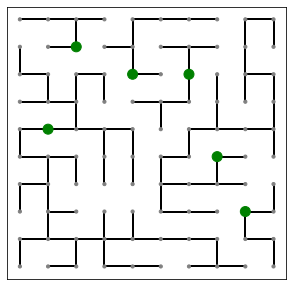

+---------------+
| SIMULAZIONE 1 |
+---------------+
The roots are: [(3, 4), (2, 7), (4, 3), (6, 4), (7, 3), (8, 5), (9, 0)]
The roots get identified at iteration indices: [39, 91, 103, 134, 181, 212, 225]
The total number of iteration is: 240


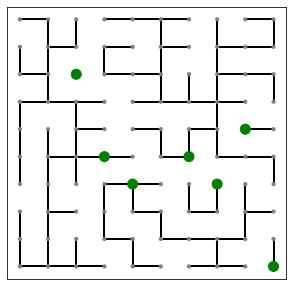

+---------------+
| SIMULAZIONE 2 |
+---------------+
The roots are: [(7, 6), (3, 3), (2, 8), (4, 4), (6, 2), (8, 2), (9, 5)]
The roots get identified at iteration indices: [27, 69, 76, 103, 134, 150, 176]
The total number of iteration is: 191


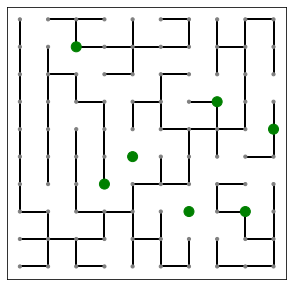

+---------------+
| SIMULAZIONE 3 |
+---------------+
The roots are: [(1, 2), (5, 5), (7, 7), (8, 1)]
The roots get identified at iteration indices: [55, 96, 209, 274]
The total number of iteration is: 289


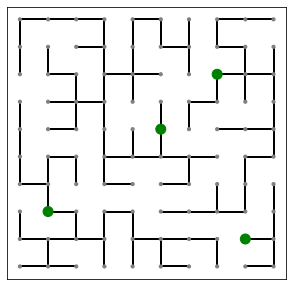

+---------------+
| SIMULAZIONE 4 |
+---------------+
The roots are: [(1, 4), (2, 7), (0, 9), (2, 9), (5, 5), (2, 6), (8, 3), (7, 7), (9, 9), (9, 7)]
The roots get identified at iteration indices: [13, 18, 23, 39, 94, 106, 208, 247, 257, 262]
The total number of iteration is: 279


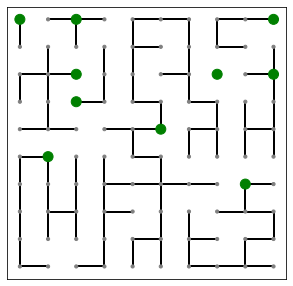

+---------------+
| SIMULAZIONE 5 |
+---------------+
The roots are: [(2, 0), (2, 4), (8, 4), (2, 9), (4, 2)]
The roots get identified at iteration indices: [6, 36, 110, 117, 124]
The total number of iteration is: 251


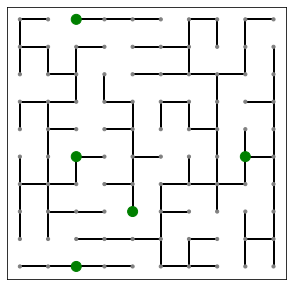

+---------------+
| SIMULAZIONE 6 |
+---------------+
The roots are: [(8, 2), (0, 8), (2, 9), (5, 6), (9, 5), (7, 3)]
The roots get identified at iteration indices: [14, 34, 49, 101, 145, 177]
The total number of iteration is: 225


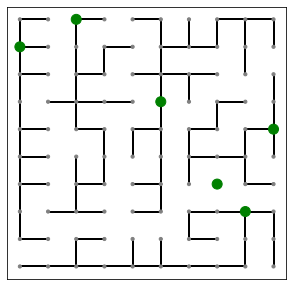

+---------------+
| SIMULAZIONE 7 |
+---------------+
The roots are: [(1, 1), (4, 9), (2, 3), (3, 3), (6, 0), (6, 9), (6, 7), (9, 1), (8, 8)]
The roots get identified at iteration indices: [10, 48, 71, 88, 109, 166, 194, 219, 239]
The total number of iteration is: 270


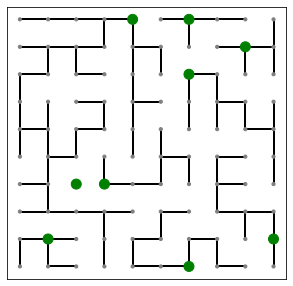

+---------------+
| SIMULAZIONE 8 |
+---------------+
The roots are: [(0, 2), (1, 3), (7, 7), (5, 8)]
The roots get identified at iteration indices: [26, 28, 67, 169]
The total number of iteration is: 254


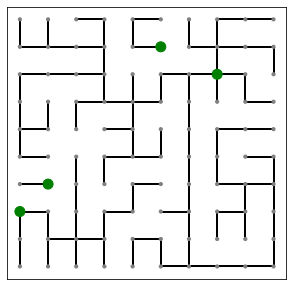

+---------------+
| SIMULAZIONE 9 |
+---------------+
The roots are: [(0, 0), (0, 5), (4, 1), (3, 7)]
The roots get identified at iteration indices: [0, 38, 92, 109]
The total number of iteration is: 336


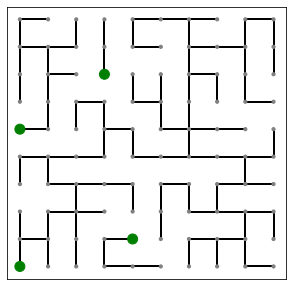

In [8]:
Wilson = []
for k in range(10):
    print("+---------------+")
    print("| SIMULAZIONE %d |" %(k))
    print("+---------------+")
    Wilson.append(wilson_RSF_grid_2d((10,10), 0.03))
    draw_RSF(Wilson[k])
    print("=============================================================================")

1 of 255
2 of 255
3 of 255
4 of 255
5 of 255
6 of 255
7 of 255
8 of 255
9 of 255
10 of 255
11 of 255
12 of 255
13 of 255
14 of 255
15 of 255
16 of 255
17 of 255
18 of 255
19 of 255
20 of 255
21 of 255
22 of 255
23 of 255
24 of 255
25 of 255
26 of 255
27 of 255
28 of 255
29 of 255
30 of 255
31 of 255
32 of 255
33 of 255
34 of 255
35 of 255
36 of 255
37 of 255
38 of 255
39 of 255
40 of 255
41 of 255
42 of 255
43 of 255
44 of 255
45 of 255
46 of 255
47 of 255
48 of 255
49 of 255
50 of 255
51 of 255
52 of 255
53 of 255
54 of 255
55 of 255
56 of 255
57 of 255
58 of 255
59 of 255
60 of 255
61 of 255
62 of 255
63 of 255
64 of 255
65 of 255
66 of 255
67 of 255
68 of 255
69 of 255
70 of 255
71 of 255
72 of 255
73 of 255
74 of 255
75 of 255
76 of 255
77 of 255
78 of 255
79 of 255
80 of 255
81 of 255
82 of 255
83 of 255
84 of 255
85 of 255
86 of 255
87 of 255
88 of 255
89 of 255
90 of 255
91 of 255
92 of 255
93 of 255
94 of 255
95 of 255
96 of 255
97 of 255
98 of 255
99 of 255
100 of 255
101 of 2

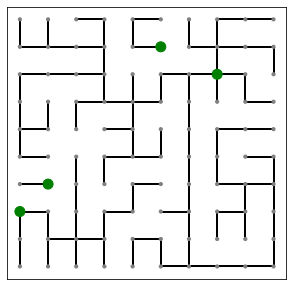

In [10]:
wilson_simulation(Wilson[8], save="wilson1")


In [11]:
# G, RW_node, edge_list, roots, root_indices = wilson_RSF_grid_2d((10,10), 0.03)
#W = wilson_RSF_grid_2d((10,10), 0.03)

#draw_RSF(W)
#wilson_simulation(W)